In [1]:
import xarray as xr
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Determine the device to use
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using CPU device


In [3]:
# Loading and combining datasets
path = "./data"
nc_files = glob.glob(os.path.join(path, "*.nc4"))
print(nc_files)
''' From original example...
datasets = [xr.open_dataset(f, engine='netcdf4') for f in nc_files]
combined_ds = xr.concat(datasets, dim='Time')
'''
combined_ds = xr.open_mfdataset(nc_files, combine='nested', 
                                parallel=True, concat_dim='Time')


['./data/conus_HUMID_20180106.nc4', './data/conus_HUMID_20180102.nc4', './data/conus_HUMID_20180104.nc4', './data/conus_HUMID_20180122.nc4', './data/conus_HUMID_20180103.nc4', './data/conus_HUMID_20180119.nc4', './data/conus_HUMID_20180101.nc4', './data/conus_HUMID_20180131.nc4', './data/conus_HUMID_20180109.nc4', './data/conus_HUMID_20180111.nc4', './data/conus_HUMID_20180126.nc4', './data/conus_HUMID_20180123.nc4', './data/conus_HUMID_20180110.nc4', './data/conus_HUMID_20180120.nc4', './data/conus_HUMID_20180124.nc4', './data/conus_HUMID_20180115.nc4', './data/conus_HUMID_20180108.nc4', './data/conus_HUMID_20180127.nc4', './data/conus_HUMID_20180129.nc4', './data/conus_HUMID_20180118.nc4', './data/conus_HUMID_20180116.nc4', './data/conus_HUMID_20180112.nc4', './data/conus_HUMID_20180107.nc4', './data/conus_HUMID_20180114.nc4', './data/conus_HUMID_20180130.nc4', './data/conus_HUMID_20180105.nc4', './data/conus_HUMID_20180121.nc4', './data/conus_HUMID_20180128.nc4', './data/conus_HUMID

/home/coder/anaconda3/envs/data_readiness/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [4]:
# Defining the config and hyperparameters
config = {
    'time_step': 1,
    'batch_size': 2,
    'num_epochs':50,
    'learning_rate': 1e-4,
    'test_size': 0.2,
}
combined_ds

<xarray.Dataset> Size: 76GB
Dimensions:            (Time: 31, lat: 2901, lon: 4608)
Coordinates:
    lat                (lat, lon) float32 53MB 22.56 22.56 22.56 ... 47.49 47.48
    lon                (lat, lon) float32 53MB 241.2 241.2 241.2 ... 295.6 295.6
Dimensions without coordinates: Time
Data variables: (12/47)
    FRC_URB2D          (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1920, 2304), meta=np.ndarray>
    HGT                (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 935, 1121), meta=np.ndarray>
    ISLTYP             (Time, lat, lon) float64 3GB dask.array<chunksize=(1, 768, 922), meta=np.ndarray>
    IVGTYP             (Time, lat, lon) float64 3GB dask.array<chunksize=(1, 935, 1121), meta=np.ndarray>
    LU_INDEX           (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1920, 2304), meta=np.ndarray>
    Lambert_Conformal  (Time) int32 124B -2147483647 -2147483647 ... -2147483647
    ...                 ...
    trad_max           (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1024, 300), meta=np.ndarray>
    trad_min           (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1024, 300), meta=np.ndarray>
    tsk                (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1024, 300), meta=np.ndarray>
    tsk_max            (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1024, 300), meta=np.ndarray>
    tsk_min            (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1024, 300), meta=np.ndarray>
    wspd               (Time, lat, lon) float32 2GB dask.array<chunksize=(1, 1024, 300), meta=np.ndarray>
Attributes: (12/50)
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        4609
    SOUTH-NORTH_GRID_DIMENSION:      3841
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      4608
    ...                              ...
    FLAG_LAI12M:                     1
    FLAG_LAKE_DEPTH:                 1
    nco_openmp_thread_number:        1
    NCO:                             netCDF Operators version 5.1.9 (Homepage...
    TITLE:                           OUTPUT FROM GEOGRID V4.0.1
    history:                         Mon Feb 26 06:21:31 2024: ncks -4 -L 1 c...

In [5]:
# Standardize the data
mean_tas = combined_ds.t2_raw.mean(dim='Time', skipna=True)
std_tas = combined_ds.t2_raw.std(dim='Time', skipna=True)

standardized_tas = (combined_ds.t2_raw - mean_tas) / std_tas

time_index = 0
standardized_tas = standardized_tas.isel(lat=slice(0,256),
                                        lon=slice(0,256))
'''
min_lat = 35.0 
max_lat = 40.0
min_lon = 230.0
max_lon = 235.0
lat_range = slice(min_lat, max_lat)  # Replace min_lat and max_lat with your desired latitude range
lon_range = slice(min_lon, max_lon)  # Replace min_lon and max_lon with your desired longitude range
print(lat_range, lon_range)
standardized_tas_slice = standardized_tas.isel(Time=time_index).sel(lat=lat_range, lon=lon_range)
'''
standardized_tas.shape

(31, 256, 256)

In [6]:
# # Fill nan values with 0s
filled_standardized_tas = standardized_tas.fillna(0)
#filled_standardized_tas = combined_ds.t2_raw.fillna(0)

expanded_data = filled_standardized_tas.values.astype(np.float32)
'''
data_shape = data.shape

if len(data_shape) < 2:
    raise ValueError("Data must have at least two dimensions for x and y.")

x_dim = data_shape[-2]
y_dim = data_shape[-1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_data = np.pad(data, ((0, 0),) * (len(data_shape) - 2) + ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)
'''
expanded_data = np.expand_dims(expanded_data, axis=1)
expanded_data.shape

(31, 1, 256, 256)

In [7]:
# Create a dataset to serve the data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, time_step=1):
        self.time_step = time_step
        self.data = data

    def __len__(self):
        return len(self.data) - self.time_step * 2

    def __getitem__(self, idx):
        '''
        return np.concatenate((self.data[idx], self.data[idx+self.time_step]), axis=0),
                               self.data[idx+self.time_step*2]
        '''
        return self.data[idx], self.data[idx+self.time_step]

dataset = TimeSeriesDataset(expanded_data)
print(dataset)

In [8]:
# Split into test and train datasets
test_size = int(len(dataset) * config['test_size'])
train_size = len(dataset) - test_size 

indices = np.arange(len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

config['batch_size'] = 2
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

In [9]:
# Define model
class CNNTimeSeriesForecast(nn.Module):
    def __init__(self, input_size, mlp_expand_size=4):
        super(CNNTimeSeriesForecast, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_size[0], 16, kernel_size=(3,3), stride=2, padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.flattened_size = self._get_flattened_size(input_size)
        '''
        self.mlp = nn.Sequential(
            nn.Linear(self.flattened_size, self.flattened_size * mlp_expand_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.flattened_size * mlp_expand_size, self.flattened_size),
        )
        '''
        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose1 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.activation = nn.ReLU()

    def _get_flattened_size(self, input_size):
        dummy_input = torch.zeros(2, *input_size)
        with torch.no_grad():
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.view(x.size(0), -1).size(1)
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        x_batch, x_channel, x_height, x_width = x3.shape
        x = x3.view(x3.size(0), -1)
        #x = self.mlp(x)
        x = x.reshape(x_batch, x_channel, x_height, x_width)

        x = x + x3
        x = self.activation(self.conv_transpose3(x))
        x = x + x2  
        x = self.activation(self.conv_transpose2(x))
        x = x + x1  
        x = self.conv_transpose1(x)

        return x

dummy_input= next(iter(test_loader))[0].to(device)
model = CNNTimeSeriesForecast(input_size=dummy_input[0].shape).to(device)

model(dummy_input).shape

torch.Size([2, 1, 256, 256])

In [10]:
'''
# Create a mask over the non-null values
non_null_mask = combined_ds.t2_raw.notnull()
collapsed_mask = np.all(non_null_mask.values, axis=0)

mask_shape = collapsed_mask.shape
x_dim = mask_shape[0]
y_dim = mask_shape[1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_mask = np.expand_dims(padded_mask, axis=0)

batch_size = config['batch_size']
batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

mask_tensor = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
mask_tensor.shape
'''

"\n# Create a mask over the non-null values\nnon_null_mask = combined_ds.t2_raw.notnull()\ncollapsed_mask = np.all(non_null_mask.values, axis=0)\n\nmask_shape = collapsed_mask.shape\nx_dim = mask_shape[0]\ny_dim = mask_shape[1]\n\ntarget_size = max(x_dim, y_dim)\nif target_size % 8 != 0:\n    target_size = ((target_size // 8) + 1) * 8\n\nx_padding = target_size - x_dim\nx_left_padding = x_padding // 2\nx_right_padding = x_padding - x_left_padding\n\ny_padding = target_size - y_dim\ny_left_padding = y_padding // 2\ny_right_padding = y_padding - y_left_padding\n\npadded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)\n\nexpanded_mask = np.expand_dims(padded_mask, axis=0)\n\nbatch_size = config['batch_size']\nbatch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)\n\nmask_tensor = torch.from_numpy(batch_mask.astype(np.float32)).to(device)\nmask_tensor.shape\n"

In [11]:
# Training set up
criterion = nn.MSELoss(reduction='none')  
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [12]:
# Training loop
for epoch in range(config['num_epochs']):
    model.train()  
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']-1}", leave=False)
    for features, labels in progress_bar:
        #print('FEATURES: ',features.shape)
        #print('LABELS: ',labels.shape)
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)

        # Apply the mask to the outputs and labels
        masked_loss = criterion(outputs, labels)# * mask_tensor
        loss = masked_loss.mean() #.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Train Loss': loss.item()})

    train_loss /= len(train_loader)

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            # Apply the mask to the outputs and labels
            masked_loss = criterion(outputs, labels)# * mask_tensor
            loss = masked_loss.mean() #.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch [{epoch}/{config['num_epochs']-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [0/49], Train Loss: 0.0041, Test Loss: 0.0186


Epoch [1/49], Train Loss: 0.0033, Test Loss: 0.0065


Epoch [2/49], Train Loss: 0.0025, Test Loss: 0.0035


Epoch [3/49], Train Loss: 0.0017, Test Loss: 0.0041


Epoch [4/49], Train Loss: 0.0011, Test Loss: 0.0081


Epoch [5/49], Train Loss: 0.0006, Test Loss: 0.0200


Epoch [6/49], Train Loss: 0.0004, Test Loss: 0.0480


Epoch [7/49], Train Loss: 0.0002, Test Loss: 0.4319


Epoch [8/49], Train Loss: 0.0002, Test Loss: 1.3991


Epoch [9/49], Train Loss: 0.0001, Test Loss: 108.4080


Epoch [10/49], Train Loss: 0.0001, Test Loss: 107.9490


Epoch [11/49], Train Loss: 0.0001, Test Loss: 0.2710


Epoch [12/49], Train Loss: 0.0001, Test Loss: 0.8656


Epoch [13/49], Train Loss: 0.0001, Test Loss: 6.9421


Epoch [14/49], Train Loss: 0.0001, Test Loss: 0.7345


Epoch [15/49], Train Loss: 0.0001, Test Loss: 5.7082


Epoch [16/49], Train Loss: 0.0001, Test Loss: 190.1840


Epoch [17/49], Train Loss: 0.0001, Test Loss: 9.9170


Epoch [18/49], Train Loss: 0.0001, Test Loss: 0.5696


Epoch [19/49], Train Loss: 0.0000, Test Loss: 30.7237


Epoch [20/49], Train Loss: 0.0000, Test Loss: 0.4799


Epoch [21/49], Train Loss: 0.0000, Test Loss: 0.1959


Epoch [22/49], Train Loss: 0.0000, Test Loss: 41.4433


Epoch [23/49], Train Loss: 0.0000, Test Loss: 14.9129


Epoch [24/49], Train Loss: 0.0000, Test Loss: 125.7534


Epoch [25/49], Train Loss: 0.0000, Test Loss: 0.0053


Epoch [26/49], Train Loss: 0.0000, Test Loss: 0.8491


Epoch [27/49], Train Loss: 0.0000, Test Loss: 0.8553


Epoch [28/49], Train Loss: 0.0000, Test Loss: 0.9725


Epoch [29/49], Train Loss: 0.0000, Test Loss: 0.8492


Epoch [30/49], Train Loss: 0.0000, Test Loss: 0.7859


Epoch [31/49], Train Loss: 0.0000, Test Loss: 0.8582


Epoch [32/49], Train Loss: 0.0000, Test Loss: 0.8420


Epoch [33/49], Train Loss: 0.0000, Test Loss: 0.9013


Epoch [34/49], Train Loss: 0.0000, Test Loss: 0.9114


Epoch [35/49], Train Loss: 0.0000, Test Loss: 3.5795


Epoch [36/49], Train Loss: 0.0000, Test Loss: 21.4964


Epoch [37/49], Train Loss: 0.0000, Test Loss: 24.8803


Epoch [38/49], Train Loss: 0.0000, Test Loss: 4.0695


Epoch [39/49], Train Loss: 0.0000, Test Loss: 0.0804


Epoch [40/49], Train Loss: 0.0000, Test Loss: 1.0077


Epoch [41/49], Train Loss: 0.0000, Test Loss: 7.1019


Epoch [42/49], Train Loss: 0.0000, Test Loss: 0.3819


Epoch [43/49], Train Loss: 0.0000, Test Loss: 2.7502


Epoch [44/49], Train Loss: 0.0000, Test Loss: 9.3583


Epoch [45/49], Train Loss: 0.0000, Test Loss: 2.4944


Epoch [46/49], Train Loss: 0.0000, Test Loss: 1.6021


Epoch [47/49], Train Loss: 0.0000, Test Loss: 0.0172


Epoch [48/49], Train Loss: 0.0000, Test Loss: 0.6618


Epoch [49/49], Train Loss: 0.0000, Test Loss: 1.1460


In [13]:
# Run the model on one example
features, labels = next(iter(test_loader))
features, labels = features.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(features)

features = features.cpu().numpy()
labels = labels.cpu().numpy()
outputs = outputs.cpu().numpy()
#mask = mask_tensor.cpu().numpy()

masked_output = outputs# * mask

difference = labels - masked_output

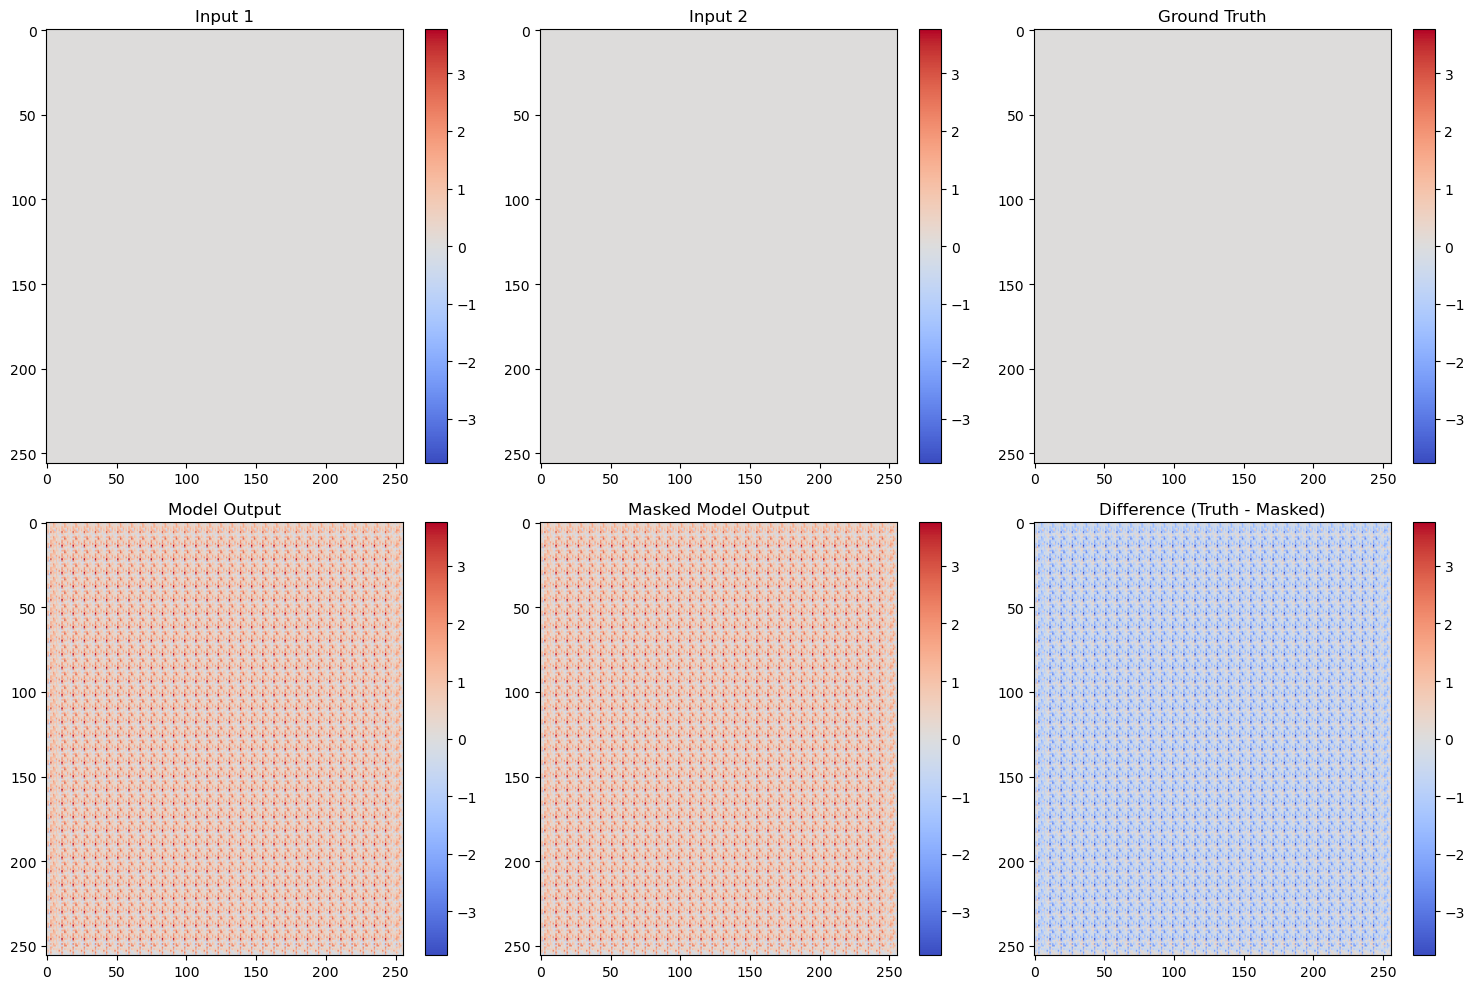

In [14]:
# Visualise the input and output data
sample_index = 1
vmin = min(features[sample_index].min(), labels[sample_index].min(), masked_output[sample_index].min(), difference[sample_index].min())
vmax = max(features[sample_index].max(), labels[sample_index].max(), masked_output[sample_index].max(), difference[sample_index].max())

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(features[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 1')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(features[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 2')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(labels[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(outputs[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Model Output')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(masked_output[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Masked Model Output')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(difference[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Difference (Truth - Masked)')
plt.colorbar()

plt.tight_layout()
plt.show()